## In history of art, there has been a burning question from centuries. Who is the better painter, few believe it's The Great Monet and rest of them say our Majnu Bhai. 
### Let's try to end the debate today 🤗️

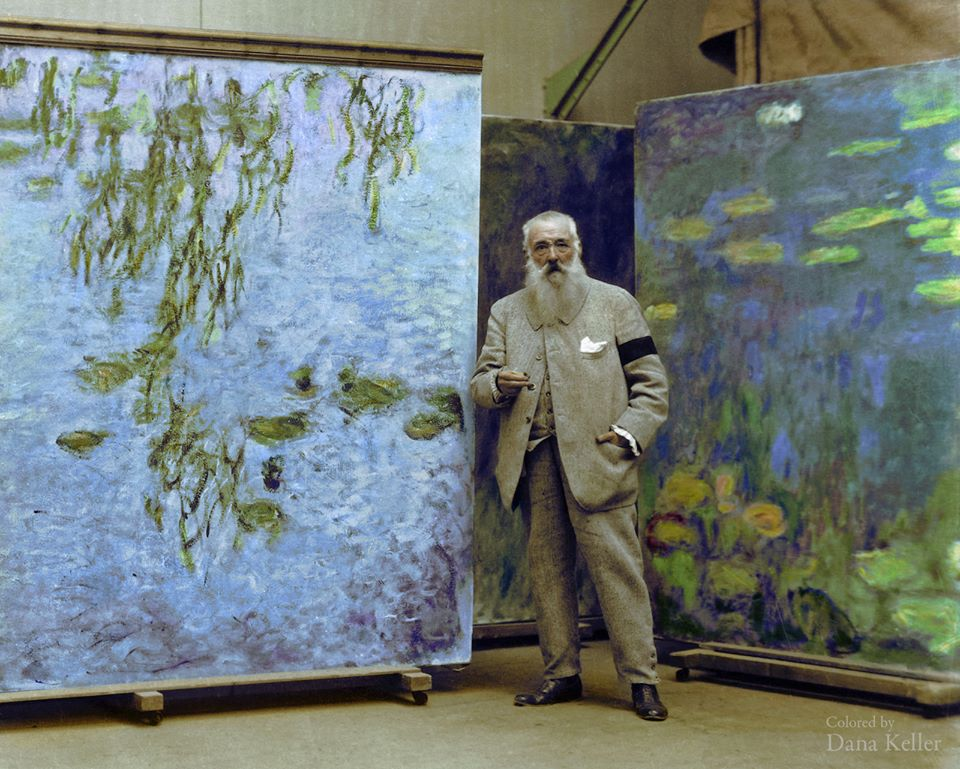

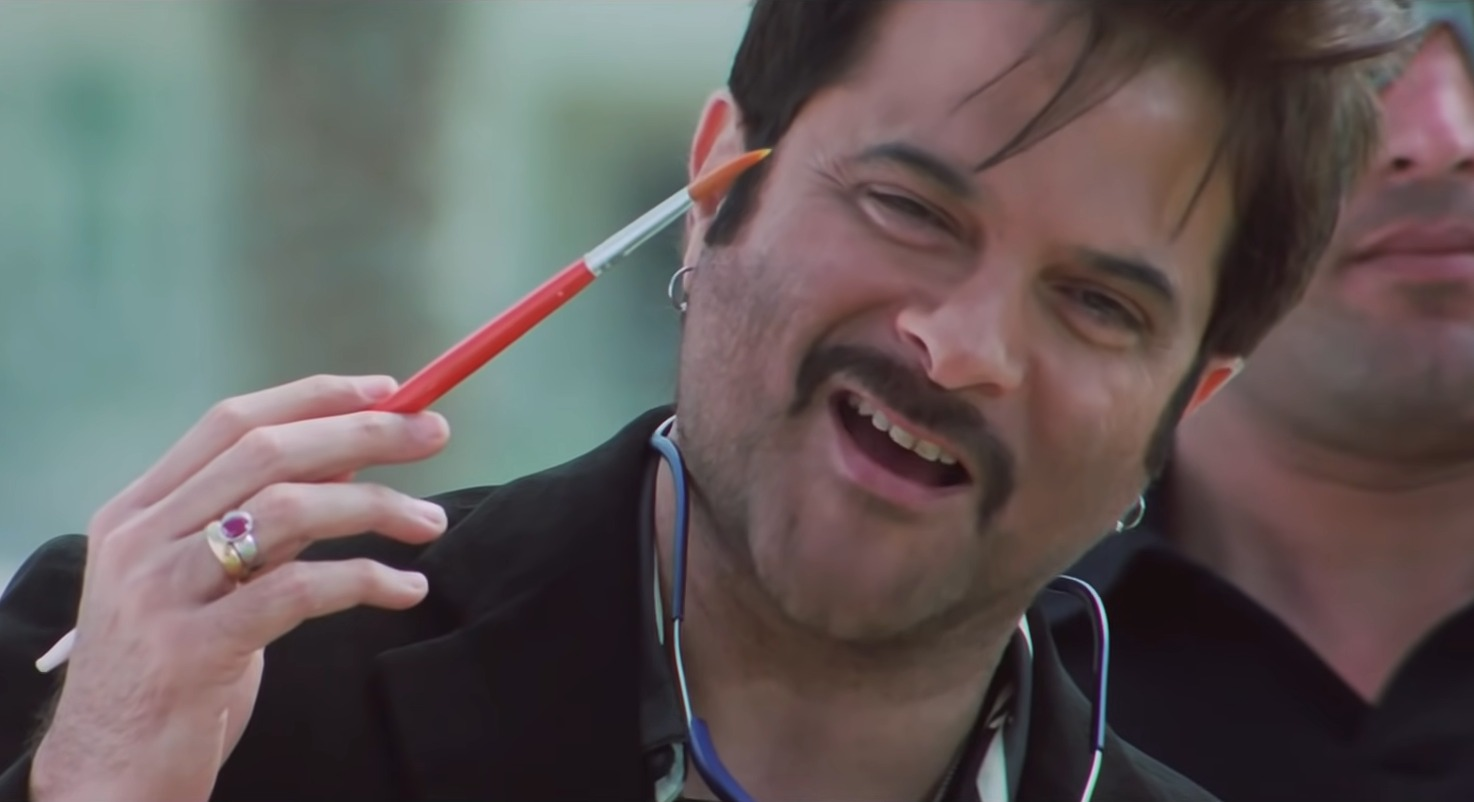

### In this notebook, we are training a CycleGAN model to see, how Monet would have painted the modern time pictures based on the photos he would see! And also we are gonna compare him with Majnu Bhai on the most famous painting... Wait for it!

## Loading data...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Time to preprocess the images

In [ ]:
gan_monet_contents = os.listdir("/kaggle/input/gan-getting-started")

In [ ]:
## I am using the tfrec files, because it's tensorflow friendly.
## I could also use the JPG files, as we have the flexibility.
monet_tfrec_path = os.path.join('/kaggle/input/gan-getting-started/', 'monet_tfrec')
photo_tfrec_path = os.path.join('/kaggle/input/gan-getting-started/', 'photo_tfrec')

In [ ]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
def _parse_function(example_proto):
    # Parse the input `tf.train.Example` proto using the feature description.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode the image and reshape
    image = tf.io.decode_jpeg(parsed_example['image'])
    image = tf.image.resize(image, [256, 256])  # Resize to desired size
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    
    return image

In [ ]:
## Gathering the tfrec Monet data
monet_dataset = tf.data.Dataset.list_files(monet_tfrec_path + '/*.tfrec')
monet_dataset = monet_dataset.interleave(tf.data.TFRecordDataset, cycle_length=4)
monet_dataset = monet_dataset.map(_parse_function)

In [ ]:
## Gathering the tfrec Photos
photo_dataset = tf.data.Dataset.list_files(photo_tfrec_path + '/*.tfrec')
photo_dataset = photo_dataset.interleave(tf.data.TFRecordDataset, cycle_length=4)
photo_dataset = photo_dataset.map(_parse_function)

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
monet_dataset = monet_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
photo_dataset = photo_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

monet_dataset, photo_dataset

# Here comes the model doo da doo doo 🎵️

In [ ]:
## Generator
def make_generator_model():
    # Reshaping the images
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # Encoder
    down1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    down2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(down1)
    down3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(down2)
    
    # Decoder
    up1 = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu')(down3)
    up2 = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu')(up1)
    
    outputs = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(up2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
## Discriminator
def make_discriminator_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    d1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    d2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(d1)
    d3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(d2)
    
    outputs = tf.keras.layers.Conv2D(1, (4, 4), padding='same')(d3)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Loss is the Boss 😎️

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [ ]:
def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

## Make the model ready to shoot!

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.3)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.3)

In [ ]:
generator_g = make_generator_model()
generator_f = make_generator_model()
discriminator_x = make_discriminator_model()
discriminator_y = make_discriminator_model()

In [ ]:
@tf.function
def train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y, 
               generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Total cycle consistency loss
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients and apply them
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


In [ ]:
# Take a sample of photos for visualization
sample_photos = next(iter(photo_dataset))
NUM_SAMPLES = 4  # Number of samples to visualize

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(12, 12))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [ ]:
EPOCHS = 80
for epoch in range(EPOCHS):
    for photo, monet in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        train_step(photo, monet, generator_g, generator_f, discriminator_x, discriminator_y, 
                   generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer)
    # Save generated images to visualize progress
    if epoch % 5 == 0 or epoch == EPOCHS - 1:  # Save images every 5 epochs
        generate_and_save_images(generator_g, epoch, sample_photos[:NUM_SAMPLES])
        generator_g.save('generator_g_model_{}.h5'.format(epoch))
        
## How beautiful it is, right!!


In [ ]:
ls

In [ ]:
generator_g = tf.keras.models.load_model('generator_g_model_79.h5')

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    image = tf.expand_dims(image, 0)  # Add batch dimension
    return image


# Converting the Photos to Monet Paintings

In [ ]:
photo_directory = '/kaggle/input/gan-getting-started/photo_jpg'
output_directory = 'converted'
os.makedirs(output_directory, exist_ok=True)

for filename in os.listdir(photo_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(photo_directory, filename)
        input_image = preprocess_image(image_path)
        transformed_image = generator_g.predict(input_image)
        transformed_image = (transformed_image + 1) * 127.5  # Denormalize to [0, 255]
        transformed_image = tf.squeeze(transformed_image).numpy().astype(np.uint8)  # Remove batch dimension and convert to uint8

        # Save the transformed image
        output_path = os.path.join(output_directory, 'monet_' + filename)
        tf.keras.preprocessing.image.save_img(output_path, transformed_image)


In [ ]:
ls converted/

## Let's save the pictures

In [ ]:
!zip -r images.zip converted

In [ ]:
ls

In [ ]:
# from IPython.display import FileLink
# FileLink(r'images.zip')

## After the training, let's see how they perform...

In [ ]:
# image_path = os.path.join('Personal_Image_Path', 'hq720.jpg')
# input_image = preprocess_image(image_path)
# transformed_image = generator_g.predict(input_image)
# transformed_image = (transformed_image) * 127.5
# output_path = os.path.join('Personal_Output_Path', 'majnu_monet.jpg')
# tf.keras.preprocessing.image.save_img(output_path, transformed_image.reshape(256, 256, 3))

## Monet

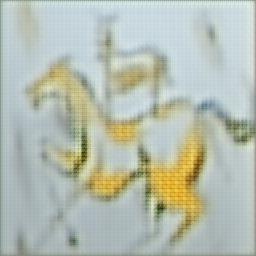

## Majnu aka Sagar 

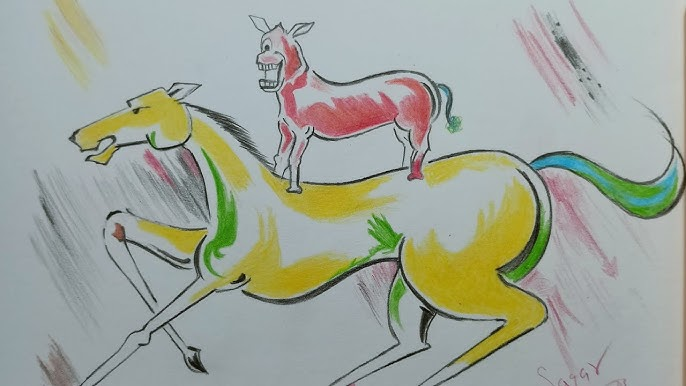

# I am not saying anything, you decide...
#### And comment who should be the winner!!
#### If you like this notebook, please do upvote 👍️